<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es5/AML_2023_HandsOn_5_MONAI_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spleen Segmentation example

Now,we will implement Spleen segmentation using the Medical Decathalon dataset. We'll follow these general steps:  

1. Transforms for dictionary format data.
2. Load Nifti image with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scale medical image intensity with expected range.
5. Crop out a batch of balanced images based on positive / negative label ratio.
6. Cache IO and transforms to accelerate training and validation.
7. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
8. Sliding window inference method.
9. Deterministic training for reproducibility.

This tutorial is derived from 
https://github.com/Project-MONAI/MONAIBootcamp2021/blob/main/day3/msd_spleen_segmentation-solution.ipynb

And

https://github.com/Project-MONAI/tutorials/blob/master/modules/transfer_mmar.ipynb

Check here for other resources on transfer learning

https://github.com/Project-MONAI/MONAI/discussions/3451


###See the slides for an example
[SLIDES](https://docs.google.com/presentation/d/1Duj8qf6L9gDZrY3qx_DmGrm85PzqBfdK97McbrlJ1ls/edit?usp=sharing)

# Turn On GPU runtime
- go to runtime
- change runtime type
- select GPU

In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"
#!python -c "import monai" || pip install -q "monai-weekly[nibabel, lmdb, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

MONAI version: 0.8.1
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.1
gdown version: 4.6.6
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Import the dataset
Spleen CT data from decathon med

In [3]:
import glob
import os

root_dir="."
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed=0)

## Now we need to build a pipeline from datafiles to the examples (cubes) we want to feed to the network

Validation and training have two different pipelines. Usually we don't want data augmentation in the training samples but the normalization pipeline has to be the same.

As usual we want that the same cropping is applied to both the image and the segmentation

In [4]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    EnsureTyped
)
#
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),# load the image
        EnsureChannelFirstd(keys=["image", "label"]),# channel first
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),# resample the volume so all the CTs have the same RESOLUTION (spatial normalization) (the clara models want a specific resolution. Check it)
        Orientationd(keys=["image", "label"], axcodes="RAS"),# Turn the volume so thath the orientation (how the patient is put in the machine) is always the same
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,# CT intensity values has a physical meaning tied to the density of the tissues so we can decide which parts are important in our case
            # usually air (and lungs) have a low density and thus low intensity (< -500)
            # bones have a very high density (>500)
            # splens like other internal organs have a density in the middle. After the intensity cut we normalize
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),# remove the background
        RandCropByPosNegLabeld(# crop patches of a give size. The number of patches that contain the spleen or not is automatically balanced (pos/neg)
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [5]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)# We will cache ("save in RAM") the dataset to speed up the training
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


In [6]:
! mkdir models
! mkdir config

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘config’: File exists


# Now we can decide if we want a pretrained model to fine tune or we want initialize a new model with random weigths.

 To speed up the training we will download an already traned model and fine tune it to our pipeline (parameters used in the pretrained model are a bit different so we can observe a small gain in the loss function using the fine tuning)

In [7]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from monai.apps import load_from_mmar
from monai.apps.mmars import RemoteMMARKeys 
#https://catalog.ngc.nvidia.com/orgs/nvidia/teams/med/models/clara_pt_spleen_ct_segmentation/version


mmar = {# definition of the model that we want. https://docs.monai.io/en/latest/_modules/monai/apps/mmars/mmars.html#load_from_mmar for details
    RemoteMMARKeys.ID: "clara_pt_spleen_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_spleen_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}


# set the flag, it will change the initial model object.
PRETRAINED = False


device = torch.device("cuda:0")

if PRETRAINED:# if this flag is active we will download the model from CLARA
    print("using a pretrained model.")
    unet_model = load_from_mmar(
        item=mmar,
        mmar_dir=root_dir,
        map_location=device,
        pretrained=True,
        api=False,
        version=1)
    
    model = unet_model
else:# else we will initialize a model of the same capacity
    print("using a randomly init. model.")
    model = UNet(
      dimensions=3,
      in_channels=1,
      out_channels=2,
      channels=(16, 32, 64, 128, 256),
      strides=(2, 2, 2, 2),
      num_res_units=2,
      norm=Norm.BATCH,
  )

model=model.to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)# Dice loss (in this case is ready to use in MONAI)
if PRETRAINED:
  optimizer = torch.optim.Adam(model.parameters(), 1e-6) # if the network is pretrained we want to use a very small learning rate because we don't want to move away from the correct minima. The network that we are downloading is almost perfect
else:
  optimizer = torch.optim.Adam(model.parameters(), 3e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

using a randomly init. model.


In [8]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 35
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])# labels are transformed to one-hot encoded vectors
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(# inference is performed with sliding window. Instead of random cubes the whole image is cubed, processed and then the prediction is put together 
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/35


/usr/local/lib/python3.9/dist-packages/monai/transforms/post/array.py:177: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


1/4, train_loss: 0.6819
2/4, train_loss: 0.6614
3/4, train_loss: 0.6341
4/4, train_loss: 0.6198
epoch 1 average loss: 0.6493
----------
epoch 2/35
1/4, train_loss: 0.6035
2/4, train_loss: 0.5975
3/4, train_loss: 0.5713
4/4, train_loss: 0.5724
epoch 2 average loss: 0.5862
----------
epoch 3/35
1/4, train_loss: 0.5735
2/4, train_loss: 0.5663
3/4, train_loss: 0.5389
4/4, train_loss: 0.5661
epoch 3 average loss: 0.5612
----------
epoch 4/35
1/4, train_loss: 0.5394
2/4, train_loss: 0.5317
3/4, train_loss: 0.5345
4/4, train_loss: 0.5344
epoch 4 average loss: 0.5350
----------
epoch 5/35
1/4, train_loss: 0.5181
2/4, train_loss: 0.5177
3/4, train_loss: 0.5121
4/4, train_loss: 0.4899
epoch 5 average loss: 0.5095
saved new best metric model
current epoch: 5 current mean dice: 0.0426
best mean dice: 0.0426 at epoch: 5
----------
epoch 6/35
1/4, train_loss: 0.5086
2/4, train_loss: 0.5116
3/4, train_loss: 0.4492
4/4, train_loss: 0.4802
epoch 6 average loss: 0.4874
----------
epoch 7/35
1/4, train_l

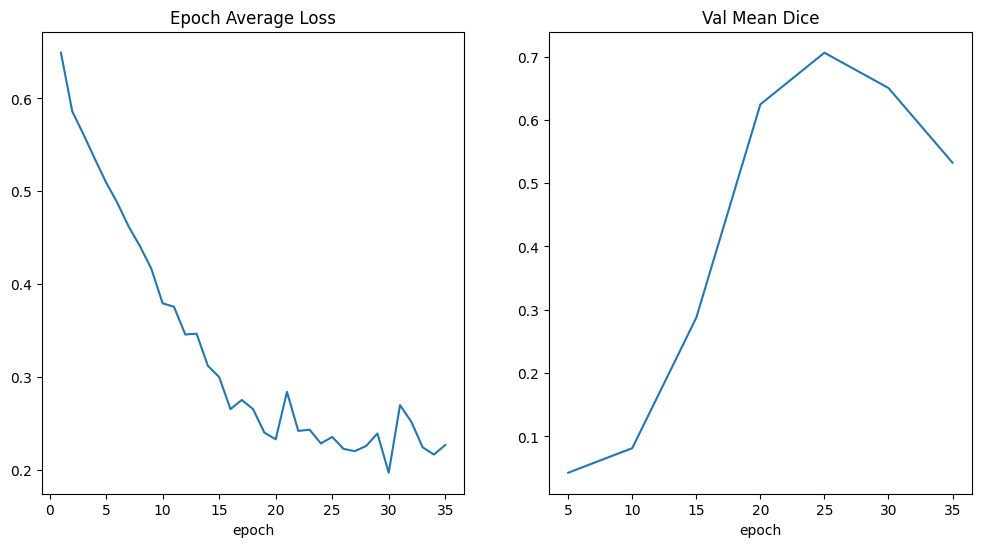

In [9]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

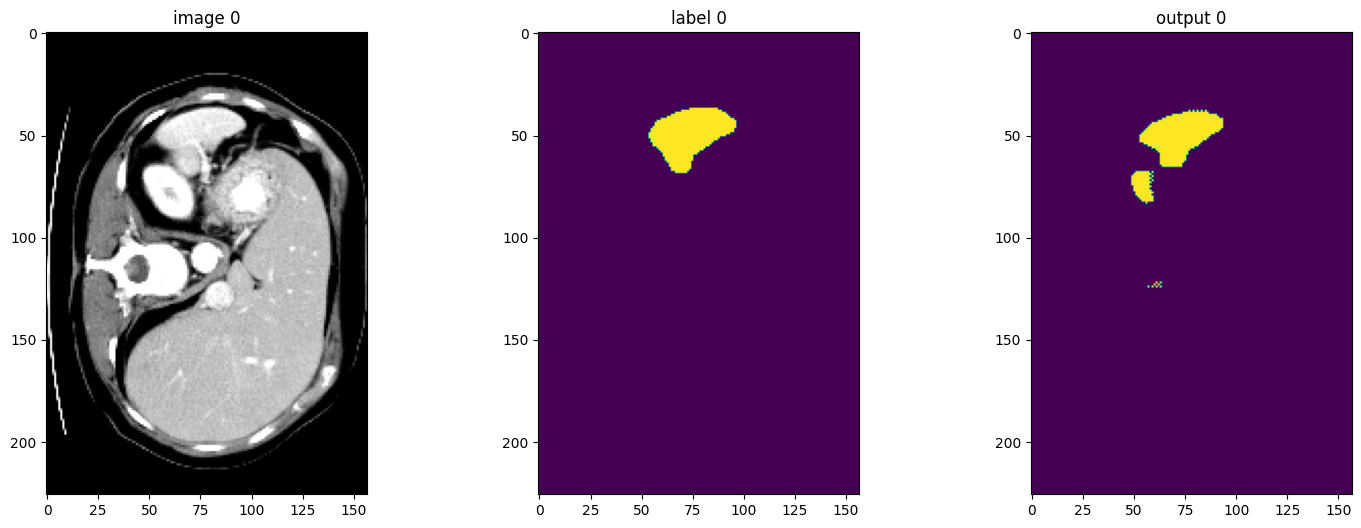

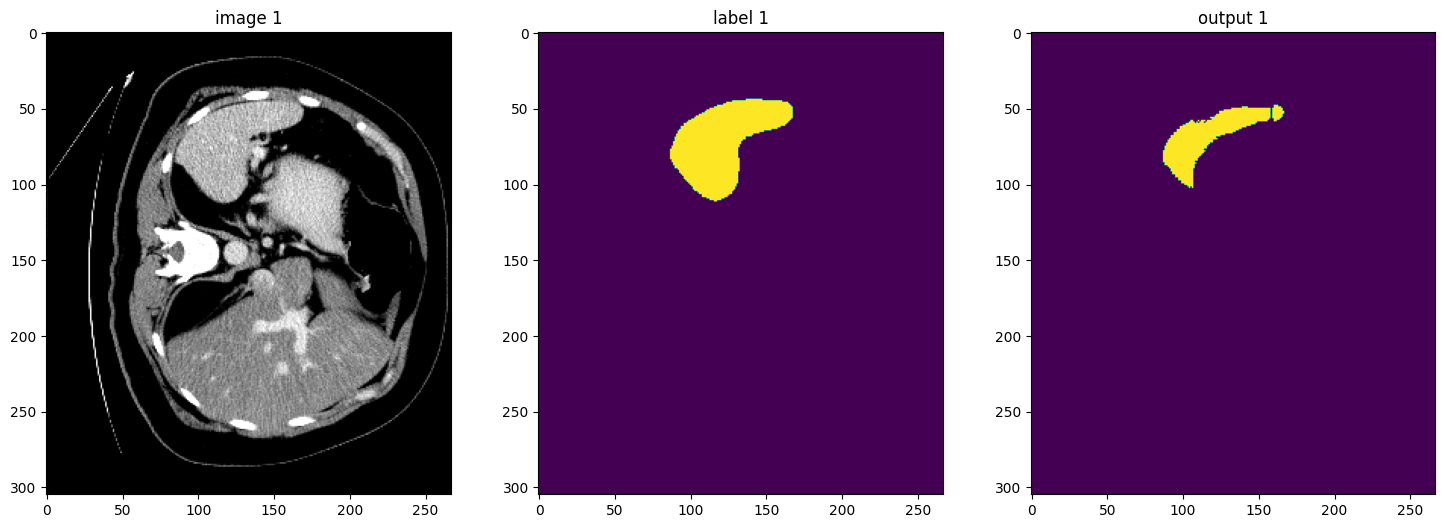

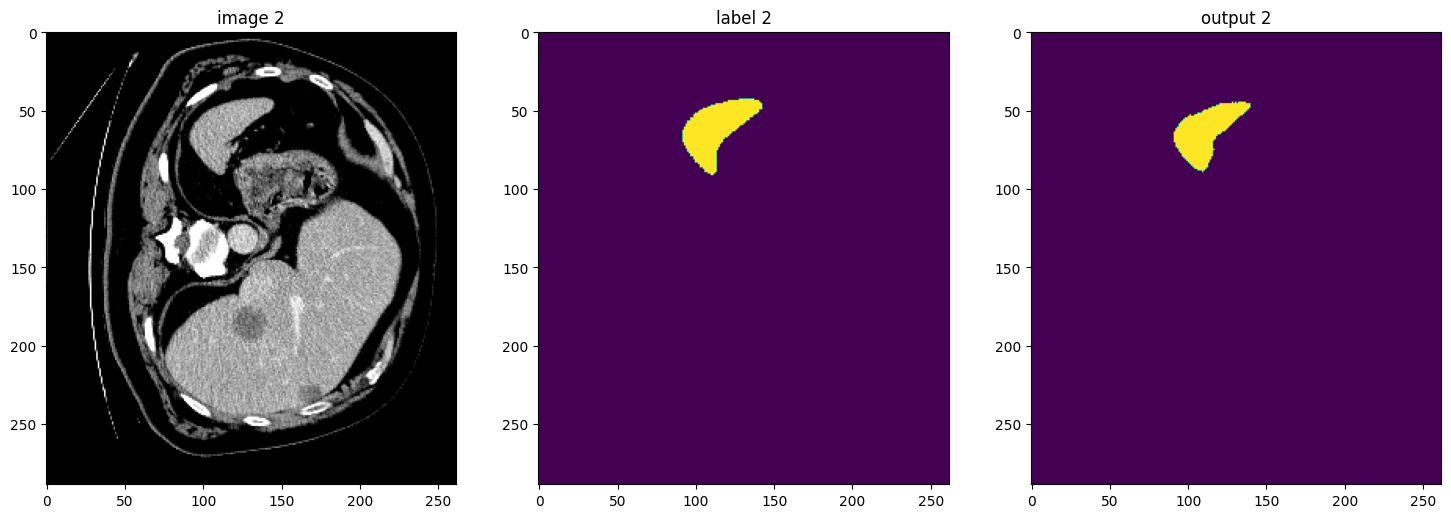

In [10]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# At home suggestions:
- Try to load a model that is not used for spleen segmentation from https://catalog.ngc.nvidia.com/models

- Check if a pretrained model on a similar task (prastate segmentation, for example) will converge faster on the spleen dataset than an untrained model of the same capacity
- Add other transformation to the pipeline. For example try to implement the noise addiction and image deformation.